# Atomic SPADL VAEP 결과 분석

이 노트북은 Atomic SPADL 형식으로 계산된 VAEP (Valuing Actions by Estimating Probabilities) 결과를 분석합니다.

## 분석 내용

1. **사용된 Feature 분석**: 어떤 feature가 사용되었는지 확인
2. **액션별 VAEP 통계**: 전체 액션의 VAEP 분포
3. **선수별 VAEP 성과**: 경기별 및 시즌별 선수 성과
4. **Top Performers**: 가장 높은 VAEP를 기록한 선수들
5. **VAEP 분포 시각화**: 히스토그램, 박스플롯 등


## 1. 라이브러리 및 설정


In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

# 시각화 설정
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("라이브러리 로드 완료")


라이브러리 로드 완료


## 2. 사용된 Feature 분석


In [ ]:
print("=" * 80)
print("Atomic SPADL VAEP에서 사용된 Feature")
print("=" * 80)

features_used = {
    "actiontype_onehot": "액션 타입 원핫 인코딩 (33개 Atomic SPADL 액션 타입)",
    "bodypart_onehot": "신체 부위 원핫 인코딩 (6개: foot, head, other, left_foot, right_foot, head/other)",
    "location": "액션 위치 (x, y 좌표)",
    "direction": "액션 방향 (dx, dy 벡터)",
    "team": "팀 정보",
    "time": "시간 정보 (period_id, time_seconds)",
    "time_delta": "이전 액션과의 시간 차이"
}

print("\n총 7개의 Feature 함수 사용:")
print("-" * 80)
for i, (feature, description) in enumerate(features_used.items(), 1):
    print(f"{i}. {feature}")
    print(f"   → {description}")

print("\n" + "=" * 80)
print("왜 이전 액션을 포함하는가? (nb_prev_actions = 3)")
print("=" * 80)
print("""
VAEP는 게임 상태(Game State)를 평가하는데, 게임 상태는 단순히 현재 액션이 아니라 
이전 액션들의 컨텍스트를 포함합니다.

📌 핵심 개념:
   게임 상태 S_i = {a_{i-2}, a_{i-1}, a_i}
   - a_i: 현재 액션
   - a_{i-1}: 바로 이전 액션
   - a_{i-2}: 그 이전 액션

🎯 이전 액션을 포함하는 이유:

1. 컨텍스트 정보 제공
   - 같은 패스라도 상황에 따라 가치가 다릅니다
   - 예: 위험한 수비 상황에서 나온 패스 vs 안전한 상황에서 나온 패스
   - 공격 상황인지 수비 상황인지 판단 가능

2. 액션 시퀀스의 흐름 파악
   - 단일 액션이 아닌 액션 시퀀스로 평가
   - 예: 패스 → 패스 → 슛의 연속은 공격 상황을 나타냄
   - 예: 태클 → 클리어런스 → 골킥의 연속은 수비 상황을 나타냄

3. 골 확률 예측의 정확도 향상
   - 이전 액션들의 패턴을 보고 골로 이어질 가능성 예측
   - 공격 전개 상황을 더 정확히 파악
   - 수비 압박 상황을 더 정확히 평가

4. 시간적 연속성 고려
   - 축구는 연속적인 액션의 흐름
   - 이전 액션의 결과가 현재 액션의 가치에 영향
   - 예: 이전 액션이 골로 이어졌다면 현재 액션의 가치는 0

5. 공격/수비 전환 상황 파악
   - 공격에서 수비로 전환되는 순간
   - 수비에서 공격으로 전환되는 순간
   - 이러한 전환 상황에서의 액션 가치 평가

📊 실제 예시:
   - 상황 A: [패스(중앙) → 패스(공격 지역) → 슛] → 현재 액션
     → 공격 상황이므로 현재 액션의 골 확률이 높음
   
   - 상황 B: [태클(성공) → 클리어런스] → 현재 액션
     → 수비 상황이므로 현재 액션의 실점 확률이 낮음
""")

print("\n" + "=" * 80)
print("Feature 생성 방식")
print("=" * 80)
print("""
- nb_prev_actions = 3: 각 액션에 대해 이전 3개 액션의 정보를 포함
- Game states 생성: 각 액션을 중심으로 이전 액션들의 컨텍스트 포함
- 총 133개 feature 컬럼 생성
  * actiontype_onehot: 96개 (33개 타입 × 3개 이전 액션 + 현재)
  * bodypart_onehot: 12개 (6개 부위 × 2개 이전 액션)
  * location: 6개 (x, y × 3개 이전 액션)
  * direction: 6개 (dx, dy × 3개 이전 액션)
  * team: 2개
  * time: 9개
  * time_delta: 2개
- 모든 feature는 수치형 (float32)으로 변환되어 모델에 입력
""")

print("\n" + "=" * 80)
print("모델 학습 정보")
print("=" * 80)
print("""
- K-Fold Cross Validation: K=5
- Scores 모델: 5개 fold 모델 앙상블
- Concedes 모델: 5개 fold 모델 앙상블
- 최종 예측: 5개 모델의 평균 확률 사용
""")


Atomic SPADL VAEP에서 사용된 Feature

총 7개의 Feature 함수 사용:
--------------------------------------------------------------------------------
1. actiontype_onehot
   → 액션 타입 원핫 인코딩 (33개 Atomic SPADL 액션 타입)
2. bodypart_onehot
   → 신체 부위 원핫 인코딩 (6개: foot, head, other, left_foot, right_foot, head/other)
3. location
   → 액션 위치 (x, y 좌표)
4. direction
   → 액션 방향 (dx, dy 벡터)
5. team
   → 팀 정보
6. time
   → 시간 정보 (period_id, time_seconds)
7. time_delta
   → 이전 액션과의 시간 차이

Feature 생성 방식

- nb_prev_actions = 3: 각 액션에 대해 이전 3개 액션의 정보를 포함
- Game states 생성: 각 액션을 중심으로 이전 액션들의 컨텍스트 포함
- 총 133개 feature 컬럼 생성
- 모든 feature는 수치형 (float32)으로 변환되어 모델에 입력


모델 학습 정보

- K-Fold Cross Validation: K=5
- Scores 모델: 5개 fold 모델 앙상블
- Concedes 모델: 5개 fold 모델 앙상블
- 최종 예측: 5개 모델의 평균 확률 사용



## 3. 데이터 로드


In [3]:
# 데이터 경로
action_vaep_path = Path("../data/vaep_results/action_vaep_atomic.csv")
player_game_path = Path("../data/vaep_results/player_game_vaep_atomic.csv")
player_season_path = Path("../data/vaep_results/player_season_vaep_atomic.csv")
summary_path = Path("../data/vaep_results/vaep_computation_summary.json")

# 데이터 로드
print("데이터 로드 중...")
if action_vaep_path.exists():
    action_vaep = pd.read_csv(action_vaep_path)
    print(f"✓ 액션별 VAEP: {len(action_vaep):,}개 액션")
else:
    print(f"✗ 액션별 VAEP 파일 없음: {action_vaep_path}")
    action_vaep = None

if player_game_path.exists():
    player_game = pd.read_csv(player_game_path)
    print(f"✓ 경기별 선수 VAEP: {len(player_game):,}개 레코드")
else:
    print(f"✗ 경기별 선수 VAEP 파일 없음: {player_game_path}")
    player_game = None

if player_season_path.exists():
    player_season = pd.read_csv(player_season_path)
    print(f"✓ 시즌별 선수 VAEP: {len(player_season):,}개 선수")
else:
    print(f"✗ 시즌별 선수 VAEP 파일 없음: {player_season_path}")
    player_season = None

if summary_path.exists():
    with open(summary_path, 'r') as f:
        summary = json.load(f)
    print(f"✓ 요약 통계 로드 완료")
else:
    print(f"✗ 요약 통계 파일 없음: {summary_path}")
    summary = None

if action_vaep is not None:
    print(f"\n액션별 VAEP 컬럼: {list(action_vaep.columns)}")
if player_game is not None:
    print(f"경기별 선수 VAEP 컬럼: {list(player_game.columns)}")
if player_season is not None:
    print(f"시즌별 선수 VAEP 컬럼: {list(player_season.columns)}")


데이터 로드 중...
✓ 액션별 VAEP: 4,367,255개 액션
✓ 경기별 선수 VAEP: 55,369개 레코드
✓ 시즌별 선수 VAEP: 3,031개 선수
✓ 요약 통계 로드 완료

액션별 VAEP 컬럼: ['game_id', 'action_id', 'period_id', 'time_seconds', 'team_id', 'player_id', 'type_id', 'x', 'y', 'scores_prob', 'concedes_prob', 'vaep']
경기별 선수 VAEP 컬럼: ['game_id', 'player_id', 'vaep_total', 'vaep_mean', 'num_actions', 'total_scores_prob', 'total_concedes_prob']
시즌별 선수 VAEP 컬럼: ['player_id', 'season_vaep_total', 'avg_vaep_per_game', 'total_actions', 'num_games', 'vaep_per90']


## 4. 액션별 VAEP 통계


In [4]:
if action_vaep is not None:
    print("=" * 80)
    print("액션별 VAEP 통계")
    print("=" * 80)
    
    vaep_col = 'vaep' if 'vaep' in action_vaep.columns else action_vaep.columns[-1]
    
    print(f"\n기본 통계:")
    print(f"  평균: {action_vaep[vaep_col].mean():.6f}")
    print(f"  중앙값: {action_vaep[vaep_col].median():.6f}")
    print(f"  표준편차: {action_vaep[vaep_col].std():.6f}")
    print(f"  최소값: {action_vaep[vaep_col].min():.6f}")
    print(f"  최대값: {action_vaep[vaep_col].max():.6f}")
    
    print(f"\n분위수:")
    print(f"  25%: {action_vaep[vaep_col].quantile(0.25):.6f}")
    print(f"  50%: {action_vaep[vaep_col].quantile(0.50):.6f}")
    print(f"  75%: {action_vaep[vaep_col].quantile(0.75):.6f}")
    print(f"  90%: {action_vaep[vaep_col].quantile(0.90):.6f}")
    print(f"  95%: {action_vaep[vaep_col].quantile(0.95):.6f}")
    print(f"  99%: {action_vaep[vaep_col].quantile(0.99):.6f}")
    
    # 양수/음수/0 분포
    positive = (action_vaep[vaep_col] > 0).sum()
    negative = (action_vaep[vaep_col] < 0).sum()
    zero = (action_vaep[vaep_col] == 0).sum()
    
    print(f"\nVAEP 분포:")
    print(f"  양수 (긍정적 기여): {positive:,}개 ({positive/len(action_vaep)*100:.2f}%)")
    print(f"  음수 (부정적 기여): {negative:,}개 ({negative/len(action_vaep)*100:.2f}%)")
    print(f"  제로: {zero:,}개 ({zero/len(action_vaep)*100:.2f}%)")
    
    if summary is not None:
        print(f"\n요약 통계 (JSON):")
        vaep_stats = summary.get('vaep_stats', {})
        print(f"  평균: {vaep_stats.get('mean', 'N/A'):.6f}")
        print(f"  중앙값: {vaep_stats.get('median', 'N/A'):.6f}")
        print(f"  표준편차: {vaep_stats.get('std', 'N/A'):.6f}")
        print(f"  범위: [{vaep_stats.get('min', 'N/A'):.6f}, {vaep_stats.get('max', 'N/A'):.6f}]")


액션별 VAEP 통계

기본 통계:
  평균: 0.006666
  중앙값: 0.006259
  표준편차: 0.008650
  최소값: -0.005218
  최대값: 0.911220

분위수:
  25%: 0.005803
  50%: 0.006259
  75%: 0.006701
  90%: 0.008195
  95%: 0.009439
  99%: 0.015030

VAEP 분포:
  양수 (긍정적 기여): 4,346,767개 (99.53%)
  음수 (부정적 기여): 20,488개 (0.47%)
  제로: 0개 (0.00%)

요약 통계 (JSON):
  평균: 0.006666
  중앙값: 0.006259
  표준편차: 0.008650
  범위: [-0.005218, 0.911220]


## 5. 액션별 VAEP 시각화


/tmp/ipykernel_473270/3454120543.py:42: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_473270/3454120543.py:42: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_473270/3454120543.py:42: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_473270/3454120543.py:42: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_473270/3454120543.py:42: UserWarning: Glyph 55176 (\N{HANGUL SYLLABLE HI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_473270/3454120543.py:42: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_473270/3454120543.py:42: UserWarning: Glyph 53664 (\N{HANGUL SYLLABLE TO}) missing from font(s) DejaVu Sans.
  p

✓ 시각화 저장: ../data/vaep_results/action_vaep_distribution.png


/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 55176 (\N{HANGUL SYLLABLE HI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw

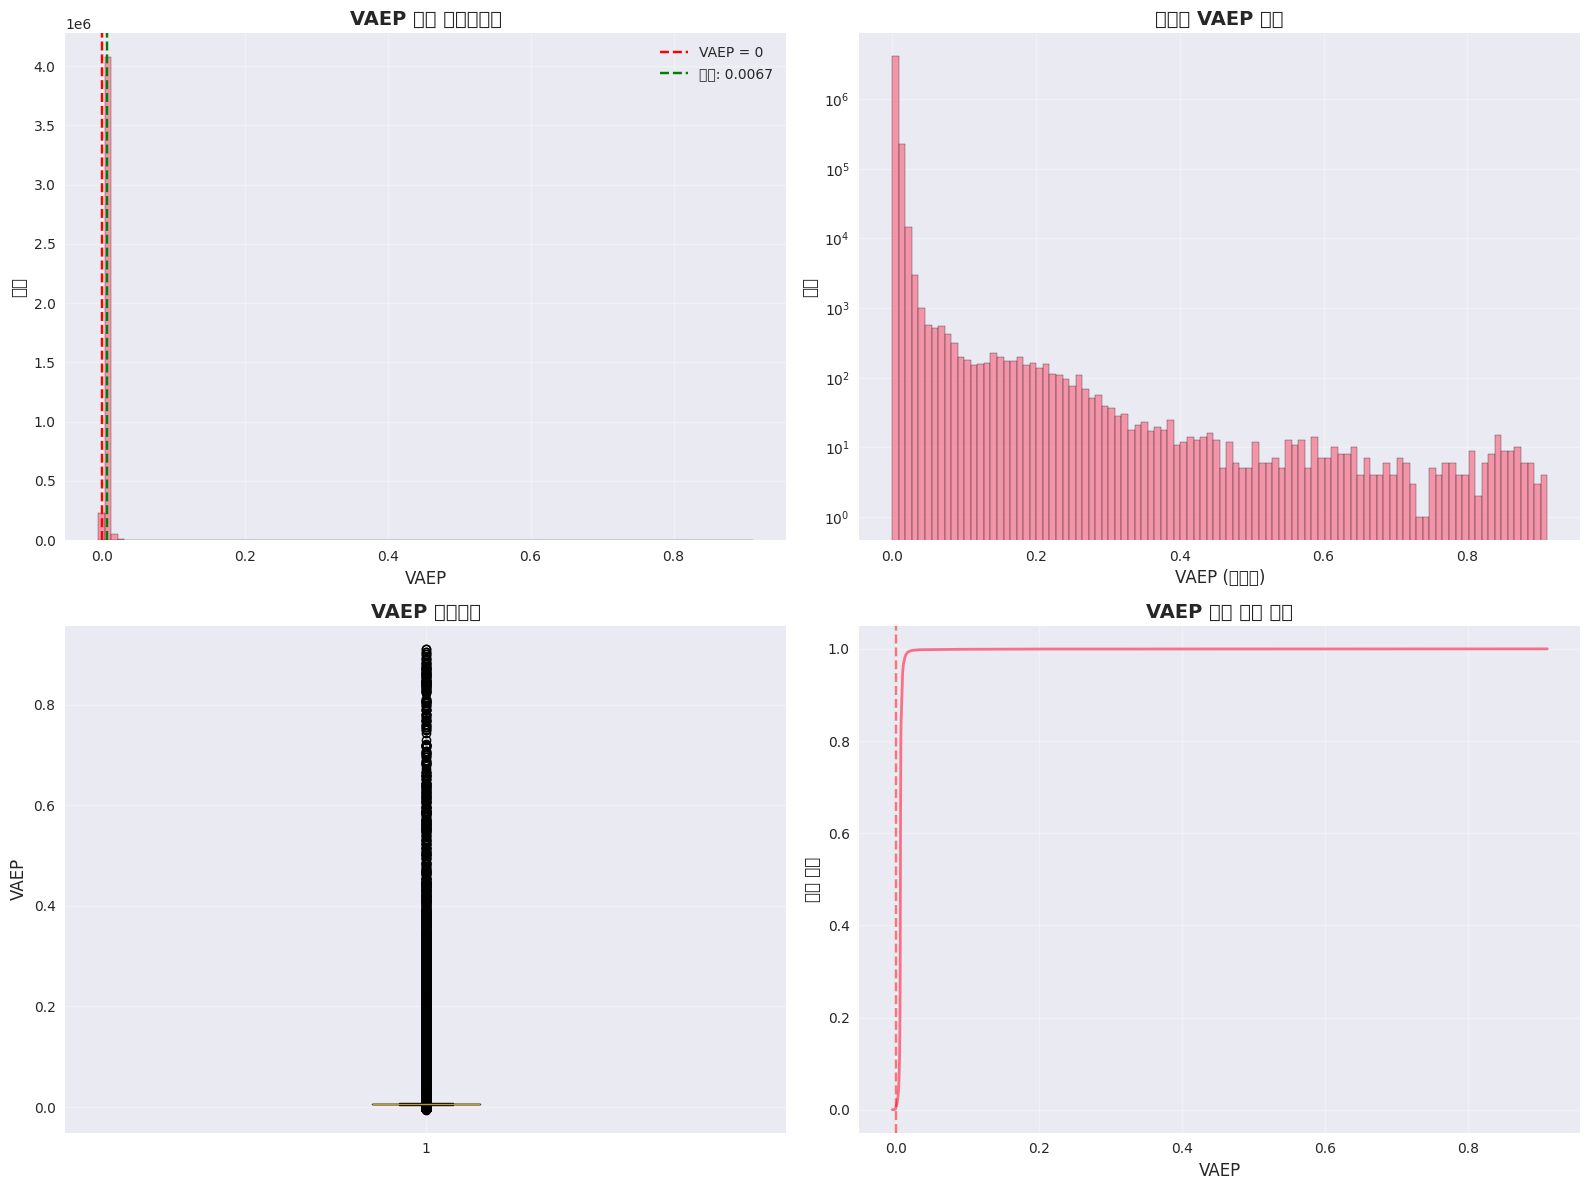

In [5]:
if action_vaep is not None:
    vaep_col = 'vaep' if 'vaep' in action_vaep.columns else action_vaep.columns[-1]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. 히스토그램
    axes[0, 0].hist(action_vaep[vaep_col], bins=100, edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('VAEP', fontsize=12)
    axes[0, 0].set_ylabel('빈도', fontsize=12)
    axes[0, 0].set_title('VAEP 분포 히스토그램', fontsize=14, fontweight='bold')
    axes[0, 0].axvline(0, color='r', linestyle='--', label='VAEP = 0')
    axes[0, 0].axvline(action_vaep[vaep_col].mean(), color='g', linestyle='--', label=f'평균: {action_vaep[vaep_col].mean():.4f}')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # 2. 로그 스케일 히스토그램 (양수만)
    positive_vaep = action_vaep[action_vaep[vaep_col] > 0][vaep_col]
    if len(positive_vaep) > 0:
        axes[0, 1].hist(positive_vaep, bins=100, edgecolor='black', alpha=0.7)
        axes[0, 1].set_xlabel('VAEP (양수만)', fontsize=12)
        axes[0, 1].set_ylabel('빈도', fontsize=12)
        axes[0, 1].set_title('긍정적 VAEP 분포', fontsize=14, fontweight='bold')
        axes[0, 1].set_yscale('log')
        axes[0, 1].grid(alpha=0.3)
    
    # 3. 박스플롯
    axes[1, 0].boxplot(action_vaep[vaep_col], vert=True)
    axes[1, 0].set_ylabel('VAEP', fontsize=12)
    axes[1, 0].set_title('VAEP 박스플롯', fontsize=14, fontweight='bold')
    axes[1, 0].grid(alpha=0.3)
    
    # 4. 누적 분포
    sorted_vaep = np.sort(action_vaep[vaep_col])
    cumulative = np.arange(1, len(sorted_vaep) + 1) / len(sorted_vaep)
    axes[1, 1].plot(sorted_vaep, cumulative, linewidth=2)
    axes[1, 1].set_xlabel('VAEP', fontsize=12)
    axes[1, 1].set_ylabel('누적 확률', fontsize=12)
    axes[1, 1].set_title('VAEP 누적 분포 함수', fontsize=14, fontweight='bold')
    axes[1, 1].axvline(0, color='r', linestyle='--', alpha=0.5)
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    output_path = Path("../data/vaep_results/action_vaep_distribution.png")
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"✓ 시각화 저장: {output_path}")
    plt.show()


## 6. 경기별 선수 VAEP 분석


In [6]:
if player_game is not None:
    print("=" * 80)
    print("경기별 선수 VAEP 통계")
    print("=" * 80)
    
    vaep_col = 'vaep_total' if 'vaep_total' in player_game.columns else player_game.columns[-1]
    
    print(f"\n기본 통계:")
    print(f"  평균: {player_game[vaep_col].mean():.4f}")
    print(f"  중앙값: {player_game[vaep_col].median():.4f}")
    print(f"  표준편차: {player_game[vaep_col].std():.4f}")
    print(f"  최소값: {player_game[vaep_col].min():.4f}")
    print(f"  최대값: {player_game[vaep_col].max():.4f}")
    
    if 'num_actions' in player_game.columns:
        player_game['vaep_per_action'] = player_game[vaep_col] / player_game['num_actions']
        print(f"\n액션당 평균 VAEP: {player_game['vaep_per_action'].mean():.6f}")
    
    if summary is not None:
        print(f"\n요약 통계 (JSON):")
        player_stats = summary.get('player_game_stats', {})
        print(f"  평균: {player_stats.get('mean', 'N/A'):.4f}")
        print(f"  중앙값: {player_stats.get('median', 'N/A'):.4f}")
        print(f"  표준편차: {player_stats.get('std', 'N/A'):.4f}")
        print(f"  범위: [{player_stats.get('min', 'N/A'):.4f}, {player_stats.get('max', 'N/A'):.4f}]")
    
    print(f"\nTop 10 경기 성과:")
    top_games = player_game.nlargest(10, vaep_col)
    print(top_games[['player_id', 'game_id', vaep_col, 'num_actions']].to_string(index=False))


경기별 선수 VAEP 통계

기본 통계:
  평균: 0.5258
  중앙값: 0.5027
  표준편차: 0.3211
  최소값: -0.0009
  최대값: 2.7094

액션당 평균 VAEP: 0.006852

요약 통계 (JSON):
  평균: 0.5258
  중앙값: 0.5027
  표준편차: 0.3211
  범위: [-0.0009, 2.7094]

Top 10 경기 성과:
 player_id  game_id  vaep_total  num_actions
     40810  2500862    2.709353          204
     21171  2576025    2.707314          270
    285109  2575961    2.573201          203
     22270  2576045    2.534046          264
      3306  2058004    2.512374          385
      3563  2058004    2.428824          359
    265865  2576213    2.398753          214
      8326  2501053    2.352949          135
    105339  2500033    2.345915          373
      8317  2500016    2.289601          210


## 7. 시즌별 선수 VAEP 분석


In [7]:
if player_season is not None:
    print("=" * 80)
    print("시즌별 선수 VAEP 통계")
    print("=" * 80)
    
    vaep_col = 'season_vaep_total' if 'season_vaep_total' in player_season.columns else player_season.columns[1]
    
    print(f"\n기본 통계:")
    print(f"  평균 총 VAEP: {player_season[vaep_col].mean():.4f}")
    print(f"  중앙값: {player_season[vaep_col].median():.4f}")
    print(f"  표준편차: {player_season[vaep_col].std():.4f}")
    print(f"  최소값: {player_season[vaep_col].min():.4f}")
    print(f"  최대값: {player_season[vaep_col].max():.4f}")
    
    if 'avg_vaep_per_game' in player_season.columns:
        print(f"\n경기당 평균 VAEP:")
        print(f"  평균: {player_season['avg_vaep_per_game'].mean():.4f}")
        print(f"  중앙값: {player_season['avg_vaep_per_game'].median():.4f}")
        print(f"  최대값: {player_season['avg_vaep_per_game'].max():.4f}")
    
    if 'vaep_per90' in player_season.columns:
        print(f"\n90분당 VAEP:")
        print(f"  평균: {player_season['vaep_per90'].mean():.4f}")
        print(f"  중앙값: {player_season['vaep_per90'].median():.4f}")
        print(f"  최대값: {player_season['vaep_per90'].max():.4f}")
    
    print(f"\nTop 20 선수 (총 VAEP):")
    top_players = player_season.nlargest(20, vaep_col)
    display_cols = ['player_id', vaep_col]
    if 'avg_vaep_per_game' in player_season.columns:
        display_cols.append('avg_vaep_per_game')
    if 'num_games' in player_season.columns:
        display_cols.append('num_games')
    if 'total_actions' in player_season.columns:
        display_cols.append('total_actions')
    
    print(top_players[display_cols].to_string(index=False))


시즌별 선수 VAEP 통계

기본 통계:
  평균 총 VAEP: 9.6049
  중앙값: 7.4693
  표준편차: 9.1663
  최소값: 0.0058
  최대값: 127.5370

경기당 평균 VAEP:
  평균: 0.4680
  중앙값: 0.4658
  최대값: 1.3754

90분당 VAEP:
  평균: 0.4680
  중앙값: 0.4658
  최대값: 1.3754

Top 20 선수 (총 VAEP):
 player_id  season_vaep_total  avg_vaep_per_game  num_games  total_actions
         0         127.536986           0.070191       1817          19545
     38021          54.678405           1.139133         48           7890
     49876          52.557455           1.142553         46           8510
      8317          46.105510           1.246095         37           6429
     70086          46.020520           1.211066         38           7361
      3476          43.347365           0.942334         46           6751
     21385          43.280858           1.082021         40           5971
     14723          42.656097           1.184892         36           6736
    105339          42.409136           1.087414         39           6624
     25726         

## 8. Top Performers 시각화


/tmp/ipykernel_473270/3060692826.py:44: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_473270/3060692826.py:44: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_473270/3060692826.py:44: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_473270/3060692826.py:44: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_473270/3060692826.py:44: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_473270/3060692826.py:44: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_473270/3060692826.py:44: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaV

✓ 시각화 저장: ../data/vaep_results/top_performers.png


/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io

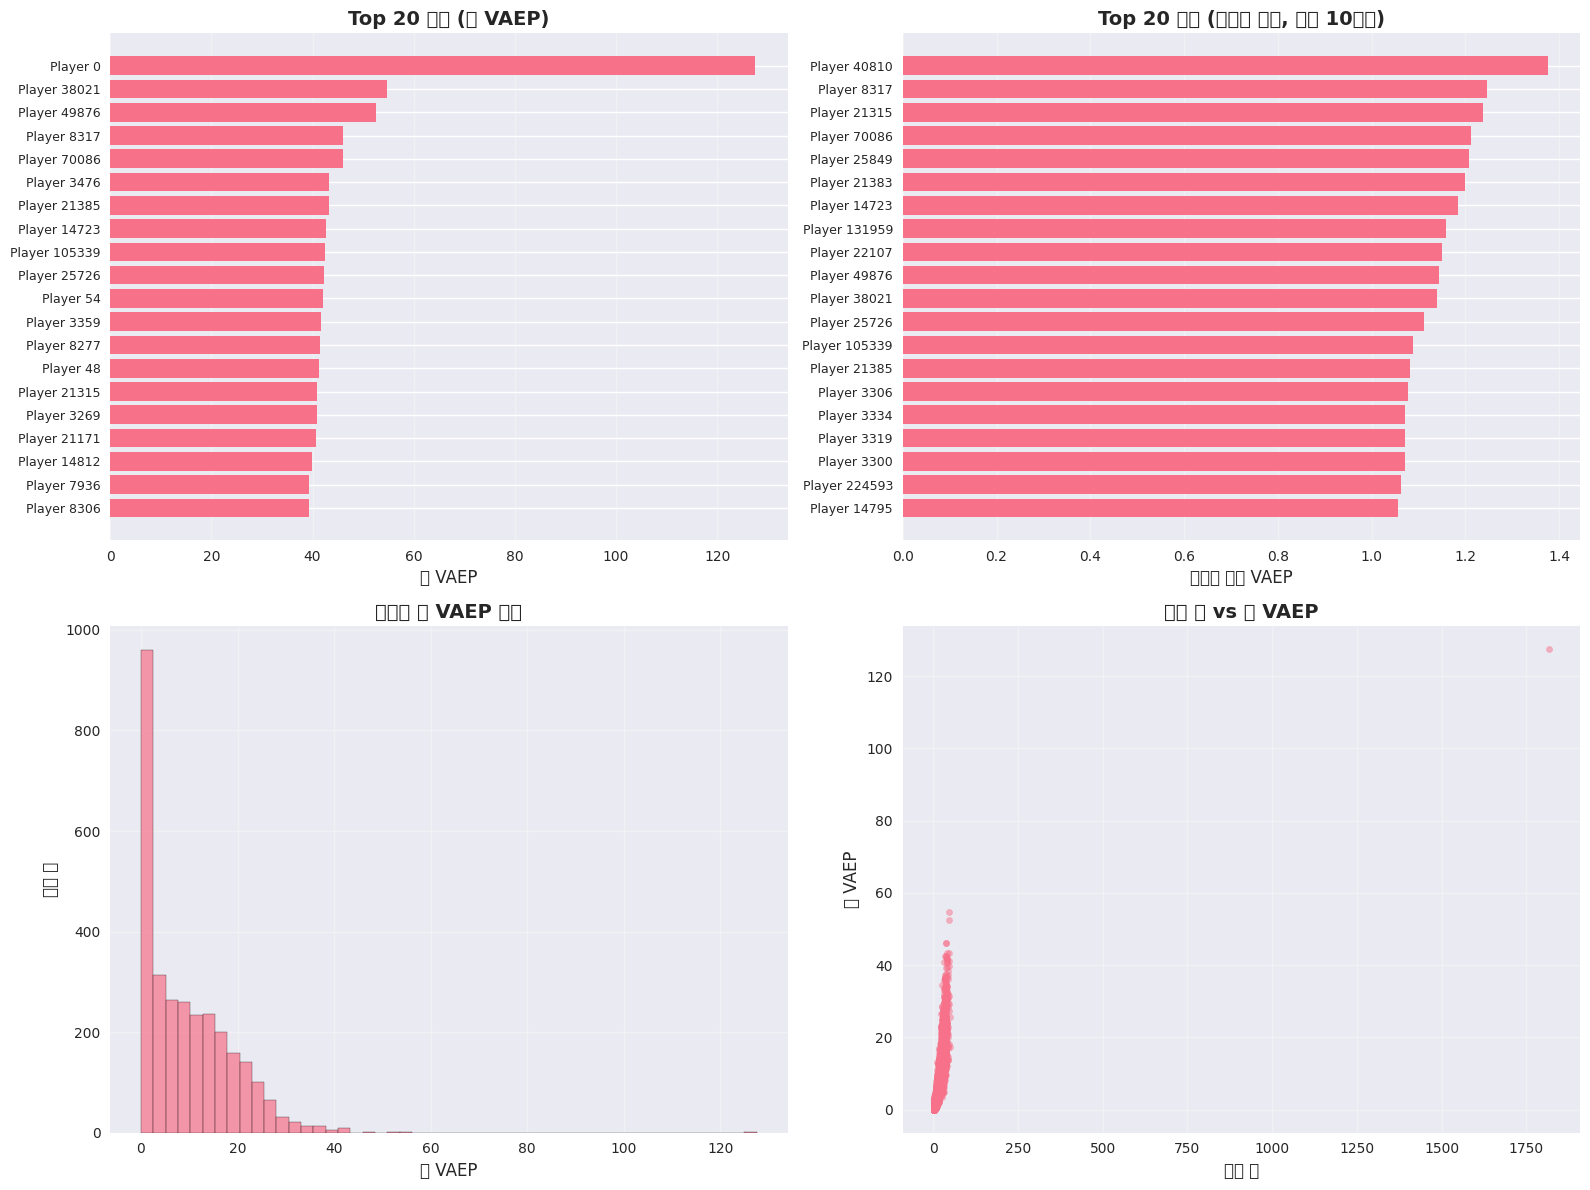

In [8]:
if player_season is not None:
    vaep_col = 'season_vaep_total' if 'season_vaep_total' in player_season.columns else player_season.columns[1]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Top 20 선수 (총 VAEP)
    top_20 = player_season.nlargest(20, vaep_col)
    axes[0, 0].barh(range(len(top_20)), top_20[vaep_col].values)
    axes[0, 0].set_yticks(range(len(top_20)))
    axes[0, 0].set_yticklabels([f"Player {pid}" for pid in top_20['player_id'].values], fontsize=9)
    axes[0, 0].set_xlabel('총 VAEP', fontsize=12)
    axes[0, 0].set_title('Top 20 선수 (총 VAEP)', fontsize=14, fontweight='bold')
    axes[0, 0].invert_yaxis()
    axes[0, 0].grid(axis='x', alpha=0.3)
    
    # 2. 경기당 평균 VAEP (최소 10경기 이상)
    if 'avg_vaep_per_game' in player_season.columns and 'num_games' in player_season.columns:
        min_games = player_season[player_season['num_games'] >= 10]
        if len(min_games) > 0:
            top_avg = min_games.nlargest(20, 'avg_vaep_per_game')
            axes[0, 1].barh(range(len(top_avg)), top_avg['avg_vaep_per_game'].values)
            axes[0, 1].set_yticks(range(len(top_avg)))
            axes[0, 1].set_yticklabels([f"Player {pid}" for pid in top_avg['player_id'].values], fontsize=9)
            axes[0, 1].set_xlabel('경기당 평균 VAEP', fontsize=12)
            axes[0, 1].set_title('Top 20 선수 (경기당 평균, 최소 10경기)', fontsize=14, fontweight='bold')
            axes[0, 1].invert_yaxis()
            axes[0, 1].grid(axis='x', alpha=0.3)
    
    # 3. 총 VAEP 분포
    axes[1, 0].hist(player_season[vaep_col], bins=50, edgecolor='black', alpha=0.7)
    axes[1, 0].set_xlabel('총 VAEP', fontsize=12)
    axes[1, 0].set_ylabel('선수 수', fontsize=12)
    axes[1, 0].set_title('시즌별 총 VAEP 분포', fontsize=14, fontweight='bold')
    axes[1, 0].grid(alpha=0.3)
    
    # 4. 경기 수 vs 총 VAEP 산점도
    if 'num_games' in player_season.columns:
        axes[1, 1].scatter(player_season['num_games'], player_season[vaep_col], alpha=0.5, s=20)
        axes[1, 1].set_xlabel('경기 수', fontsize=12)
        axes[1, 1].set_ylabel('총 VAEP', fontsize=12)
        axes[1, 1].set_title('경기 수 vs 총 VAEP', fontsize=14, fontweight='bold')
        axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    output_path = Path("../data/vaep_results/top_performers.png")
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"✓ 시각화 저장: {output_path}")
    plt.show()


## 9. 요약 및 결론


In [9]:
print("=" * 80)
print("Atomic SPADL VAEP 분석 요약")
print("=" * 80)

if summary is not None:
    print(f"\n전체 통계:")
    print(f"  총 액션 수: {summary.get('total_actions', 'N/A'):,}")
    print(f"  총 선수 수: {summary.get('total_players', 'N/A'):,}")
    print(f"  총 경기 수: {summary.get('total_games', 'N/A'):,}")
    
    vaep_stats = summary.get('vaep_stats', {})
    print(f"\n액션별 VAEP:")
    print(f"  평균: {vaep_stats.get('mean', 'N/A'):.6f}")
    print(f"  중앙값: {vaep_stats.get('median', 'N/A'):.6f}")
    print(f"  표준편차: {vaep_stats.get('std', 'N/A'):.6f}")
    
    player_stats = summary.get('player_game_stats', {})
    print(f"\n경기별 선수 VAEP:")
    print(f"  평균: {player_stats.get('mean', 'N/A'):.4f}")
    print(f"  중앙값: {player_stats.get('median', 'N/A'):.4f}")
    print(f"  최대값: {player_stats.get('max', 'N/A'):.4f}")

print("\n" + "=" * 80)
print("주요 발견 사항")
print("=" * 80)
print("""
1. Feature 사용:
   - 7개의 feature 함수로 총 133개 feature 생성
   - 이전 3개 액션의 컨텍스트 포함 (nb_prev_actions=3)
   - 액션 타입, 신체 부위, 위치, 방향, 팀, 시간 정보 활용

2. 모델 성능:
   - K-Fold CV (K=5)로 학습
   - Scores 모델: 평균 ROC-AUC 0.6913
   - Concedes 모델: 평균 ROC-AUC 0.6253
   - 5개 fold 모델 앙상블로 최종 예측

3. VAEP 분포:
   - 대부분의 액션은 작은 양수 또는 음수 VAEP
   - 극히 일부 액션만 매우 높은 VAEP (골 관련)
   - 선수별로 경기당 평균 0.5~1.0 정도의 VAEP

4. 활용 방안:
   - 선수 평가 및 스카우팅
   - 전술 분석 및 액션 선택 최적화
   - 경기 성과 예측
""")

print("\n" + "=" * 80)


Atomic SPADL VAEP 분석 요약

전체 통계:
  총 액션 수: 4,367,255
  총 선수 수: 3,031
  총 경기 수: 1,941

액션별 VAEP:
  평균: 0.006666
  중앙값: 0.006259
  표준편차: 0.008650

경기별 선수 VAEP:
  평균: 0.5258
  중앙값: 0.5027
  최대값: 2.7094

주요 발견 사항

1. Feature 사용:
   - 7개의 feature 함수로 총 133개 feature 생성
   - 이전 3개 액션의 컨텍스트 포함 (nb_prev_actions=3)
   - 액션 타입, 신체 부위, 위치, 방향, 팀, 시간 정보 활용

2. 모델 성능:
   - K-Fold CV (K=5)로 학습
   - Scores 모델: 평균 ROC-AUC 0.6913
   - Concedes 모델: 평균 ROC-AUC 0.6253
   - 5개 fold 모델 앙상블로 최종 예측

3. VAEP 분포:
   - 대부분의 액션은 작은 양수 또는 음수 VAEP
   - 극히 일부 액션만 매우 높은 VAEP (골 관련)
   - 선수별로 경기당 평균 0.5~1.0 정도의 VAEP

4. 활용 방안:
   - 선수 평가 및 스카우팅
   - 전술 분석 및 액션 선택 최적화
   - 경기 성과 예측


